In [1]:
!module load pytorch-gpu/py3/1.10.0
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-64973e24-e566-9059-2976-c8f0d810d931)


In [45]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import modellib
import datalib
import training
import conf
from multiprocessing import Pool

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
dataset = datalib.SimulationBatch.load()
dataset[0]

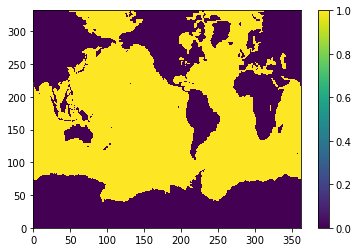

In [4]:
dataset.load_mask_bathy()
plt.pcolor(dataset.mask) ; plt.colorbar() ; plt.show()

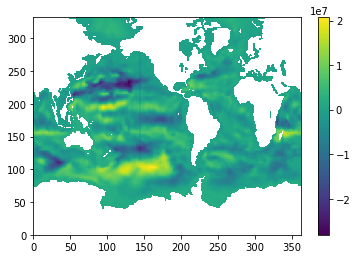

In [5]:
dataset.convert2ssca()
plt.pcolor(dataset[0][458]) ; plt.colorbar() ; plt.show()

In [6]:
dataset.infer_mask()

In [7]:
dataset.normalize(method="pointwise_stats")

In [30]:
dataset.apply_mask()

In [34]:
pca = dataset.compute_pca(2000, transform=False)

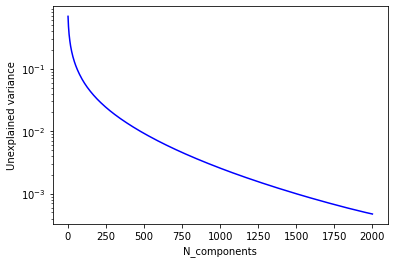

In [35]:
plt.plot(range(1, 2001), 1 - np.cumsum(pca.explained_variance_ratio_), "b-")
plt.yscale("log")
plt.ylabel("Unexplained variance")
plt.xlabel("N_components")
plt.show()

In [36]:
dataset.compute_pca(50, transform=True)
dataset.to_torch()
[(sim.shape, sim.dtype) for sim in dataset]

[((2880, 332, 362), dtype('float32')),
 ((7200, 332, 362), dtype('float32')),
 ((2880, 332, 362), dtype('float32'))]

In [37]:
dataset.make_input_indices()

In [38]:
train_ds, test_ds = dataset.train_test_ds()
print(len(train_ds), len(test_ds))

10338 2586


In [39]:
train_dataloader, test_dataloader = dataset.make_dataloaders(train_ds, test_ds)

In [40]:
model, criterion, optimizer = modellib.define_model_optimizer_criterion(pca_model=True)

Model has 126850 parameters


Epoch  1


  0%|          | 0/1293 [00:00<?, ?it/s]

  0%|          | 0/324 [00:00<?, ?it/s]

Epoch  2


  0%|          | 0/1293 [00:00<?, ?it/s]

  0%|          | 0/324 [00:00<?, ?it/s]

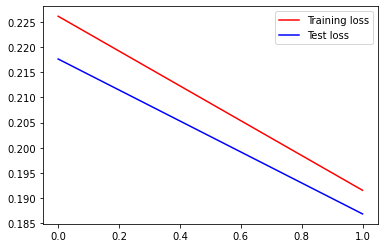

Final test loss: 0.18688951839727383


In [41]:
train_losses, test_losses = training.train(model, conf.epochs, train_dataloader, test_dataloader, optimizer, criterion, bool_mask=None)
plt.figure()
plt.plot(train_losses, "r-", label="Training loss")
if conf.epochs != 1:
    plt.plot(test_losses, "b-", label="Test loss")
plt.legend()
plt.show()
print(f"Final test loss: {test_losses[-1]}")

Chosen idx: 1357
Mean of ground truth: -0.001 ; Std of ground truth: 0.014
Mean of predicted map: 0.003 ; Std of predicted map: 0.006


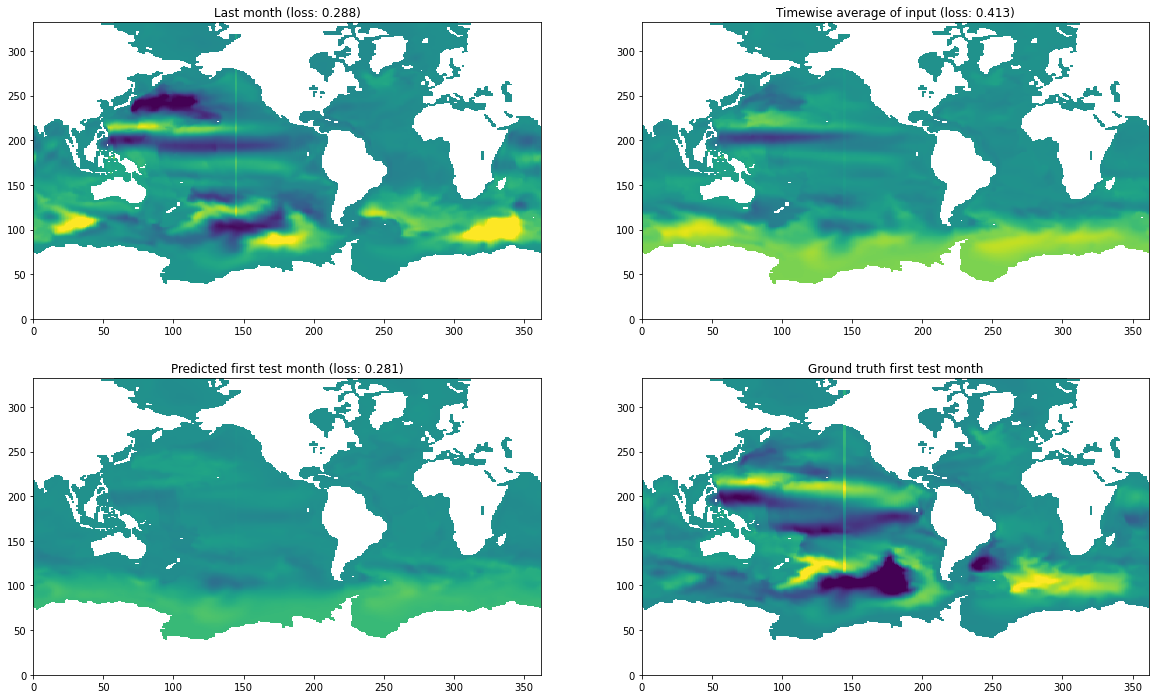

In [42]:
training.test_sample_pca(model, criterion, test_ds, dataset.bool_mask, dataset.pca)
plt.show()

  0%|          | 0/258 [00:00<?, ?it/s]

/gpfslocalsup/pub/anaconda-py3/2021.05/envs/pytorch-gpu-1.10.0+py3.9.7/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([50])) that is different to the input size (torch.Size([1, 50])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


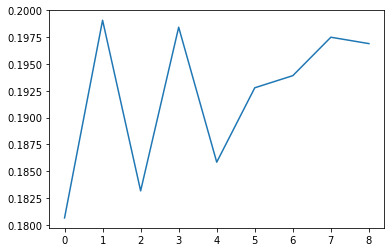

In [44]:
losses = training.quantify_quality_average(model, criterion, test_ds, dataset.bool_mask)
plt.plot(losses) ; plt.show()